# State Machine Notes

These are notes that form the basis for part of an ongoing discussion about the formulation (and foundations of) state machine formalisms and the way they can be represented in software.

Objectives:

* Show a link between state machine formalisms and implementations
* Tradeoffs between total and partial functions for implementing transition functions
* Demonstrate that type signatures and type annotations can be useful part of the process of describing software


## Mealy Machine

The formal definition of a Mealy machine is a 6-tuple $(S, S_0, \Sigma, \Lambda, T, G)$ consisting of the following:

* a finite set of states $S$
* a start state (also called initial state) $S_{0}$ which is an element of $S$
* a finite set called the input alphabet $\Sigma$ 
* a finite set called the output alphabet $\Lambda$ 
* a transition function $T : S \times \Sigma \rightarrow S$ mapping pairs of a state and an input symbol to the corresponding next state.
* an output function $G:S\times \Sigma \rightarrow \Lambda$  mapping pairs of a state and an input symbol to the corresponding output symbol.

### Questions

**How do you represent a finite set in Python?**

Consider the possible fundamental (non-associative) types available in Python: list, tuple, set, frozenset. All of these representation make sense as possible representations, with the caveat that list and tuple need extra work to prevent duplicate items. Standard library representations that make sense include enums (again with checking to prevent duplicates).

**How do you pick a suitable a finite set for a Pythonic state machine?**

* The fundamental property we're looking for in a set is a unique collection. To proove this, the members of the must  be able to be tested for equality.
* Because nothing in the formal definition calls for any changes to any of the sets, we can choose an appropriate set representation that makes immutablility obvious or easy to control.
* Because we aren't looking for subsets of any of the sets, we can choose an appropriate set representation that doesn't supply this operation.

For this reason, enums, whose set contents are created statically (unless you're trying hard to do something dynamic) may make sense in this case.

**What is an input alphabet**

An input alphabet are the events (flags / commands) that are externally supplied that can trigger a change in your state machine.

**What is an output alphabet**

An output alphabet is what you're getting your state machine to generate. 

For example, if your state-machine needs to flag that a special state (or set of states) has been reached, you do that by using an output alphabet - 0 for not reached and 1 for reached. 

*If you don't care about special outputs, it's perfectly valid (according to the formal definition), to treat the state as your output alphabet*

**How do you pick a suitable representation for the transition and output functions**

Two choices are to use a python function, or a dictionary - with dictionaries being possibly a little more succinct.

**What might a state machine class look like?**

Below

In [38]:
import typing
import itertools
from IPython.display import Image, display
from typing import *
from enum import Enum
import networkx as nx
import networkx.drawing.nx_pydot as nxdot

In [14]:
# Generic placeholder type for a member of the set of states
StateT = TypeVar('StateT')

# Generic placeholder for a member of the input alphabet set
InputT = TypeVar('InputT')

# Generic placeholder for a member of the output alphabet
OutputT = TypeVar('OutputT')

class MealyMachine(Generic[StateT, InputT, OutputT]):

    def __init__(self, initial : StateT):
        self.current = initial

    def _transition(self, state : StateT, event : InputT) -> StateT:
        raise NotImplemented('not implemented')

    def _output(self, state : StateT, event : InputT) -> OutputT:
        raise NotImplemented('not implemented')

    def step(self, event : InputT) -> OutputT:
        self.current = self._transition(self.current, event)
        output = self._output(self.current, event)
        return output

**What would sample state and transition enums look like?**

In [ ]:
class StateEnum(Enum):
    foo = 1
    bar = 2

class TransitionEnum(Enum):
    a = 1
    b = 2

**How do I use an implementation look if a dictionary described transitions?**

Below

In [5]:
class ConcreteMealy(MealyMachine[StateEnum, TransitionEnum, StateEnum]):

    def __init__(self,
                 table : Dict[Tuple[StateEnum, TransitionEnum], StateEnum],
                 *args):
        super(ConcreteMealy, self).__init__(*args)
        self.table = table

    def _transition(self, state, event):
        return self.table[(state, event)]

    def _output(self, state, event):
        return state

table = {
    (StateEnum.foo, TransitionEnum.a) : StateEnum.foo,
    (StateEnum.bar, TransitionEnum.a) : StateEnum.bar,
    (StateEnum.foo, TransitionEnum.b) : StateEnum.bar,
    (StateEnum.bar, TransitionEnum.b) : StateEnum.foo,
} 

sm = ConcreteMealy(table, StateEnum.foo)
print(sm.step(TransitionEnum.a))
print(sm.step(TransitionEnum.a))
print(sm.step(TransitionEnum.b))
print(sm.step(TransitionEnum.a))
print(sm.step(TransitionEnum.b))

StateEnum.foo
StateEnum.foo
StateEnum.bar
StateEnum.bar
StateEnum.foo


**How would that look if the transition function wasn implemented as a pure function'?**

Below

In [10]:
class ConcreteMealyWithFunc(MealyMachine[StateEnum, TransitionEnum, StateEnum]):

    def __init__(self, *args):
        super(ConcreteMealyWithFunc, self).__init__(*args)

    def _transition(self, state, event):
        if (StateEnum.foo == state) and (TransitionEnum.a == event):
            return StateEnum.foo
        elif (StateEnum.bar == state) and (TransitionEnum.a == event):
            return StateEnum.bar
        elif (StateEnum.foo == state) and (TransitionEnum.b == event):
            return StateEnum.bar
        elif (StateEnum.bar == state) and (TransitionEnum.b == event):
            return StateEnum.foo

    def _output(self, state, event):
        return state

sm = ConcreteMealyWithFunc(StateEnum.foo)
print(sm.step(TransitionEnum.a))
print(sm.step(TransitionEnum.a))
print(sm.step(TransitionEnum.b))
print(sm.step(TransitionEnum.a))
print(sm.step(TransitionEnum.b))

StateEnum.foo
StateEnum.foo
StateEnum.bar
StateEnum.bar
StateEnum.foo


**How do I make sense of this?**

Assuming that the transition function is total (that is, every input has a meaningful output), you can draw a state transition diagram.

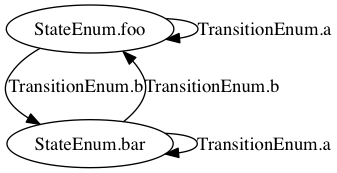

In [66]:
def tograph(machine : MealyMachine[StateT, InputT, OutputT],
            states : FrozenSet[StateT], 
            inputs : FrozenSet[InputT]) -> None:
    g = nx.DiGraph()
    for s, i in itertools.product(states, inputs):
        ns = machine._transition(s, i)
        g.add_edge(str(s), str(ns), label=str(i))
    ng = nxdot.to_pydot(g)
    data = ng.create_png(prog='dot')
    return display(Image(data))
    
        
g = tograph(sm, frozenset(StateEnum), frozenset(TransitionEnum))